In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img
import os
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score


In [2]:
# !nvidia-smi

In [3]:

def load_dataset(directory):
    images, labels = [], []
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    for category in categories:
        path_to_category = os.path.join(directory, category)
        if os.path.isdir(path_to_category):
            for file in os.listdir(path_to_category):
                full_path = os.path.join(path_to_category, file)
                if os.path.isfile(full_path):
                    with Image.open(full_path) as img:
                        img = img.resize((128, 128)).convert('RGB')
                        images.append(np.array(img))
                        labels.append(category)
    return images, labels

def convert_labels_to_one_hot(labels):
    if not labels:
        raise ValueError("No labels found. Ensure the dataset is loaded correctly.")
    label_encoder = OneHotEncoder(sparse_output=False)
    labels_as_array = np.array(labels).reshape(-1, 1)
    one_hot_labels = label_encoder.fit_transform(labels_as_array)
    return one_hot_labels


In [4]:
# Load training data
training_folder = 'archive/Training'
train_images, train_labels = load_dataset(training_folder)
train_labels_one_hot = convert_labels_to_one_hot(train_labels) #convert the test label to one hot encoded vector


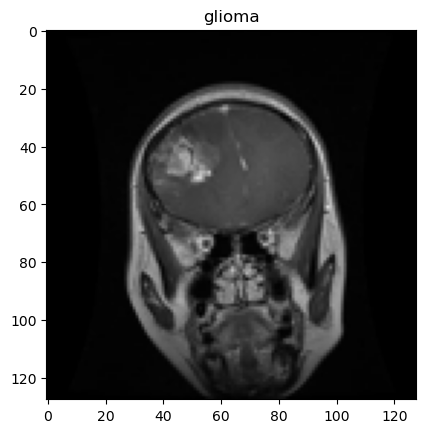

In [5]:
plt.imshow(train_images[0])
plt.title(train_labels[0])
plt.show()

In [6]:
# Load testing data
testing_folder = 'archive/Testing'
test_images, test_labels = load_dataset(testing_folder)
test_labels_one_hot = convert_labels_to_one_hot(test_labels) #convert the test label to one hot encoded vector


In [7]:
# Converting images to numpy arrays and normalize
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0


In [8]:

print(f"Training data shape: {train_images.shape}, Training labels shape: {train_labels_one_hot.shape}")
print(f"Testing data shape: {test_images.shape}, Testing labels shape: {test_labels_one_hot.shape}")



Training data shape: (5712, 128, 128, 3), Training labels shape: (5712, 4)
Testing data shape: (1311, 128, 128, 3), Testing labels shape: (1311, 4)


In [9]:
# Shuffle training data and labels
shuffle_index = np.random.permutation(len(train_images))
train_images = train_images[shuffle_index]
train_labels_one_hot = train_labels_one_hot[shuffle_index]


In [10]:
# Define class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

### Plotting some of the images

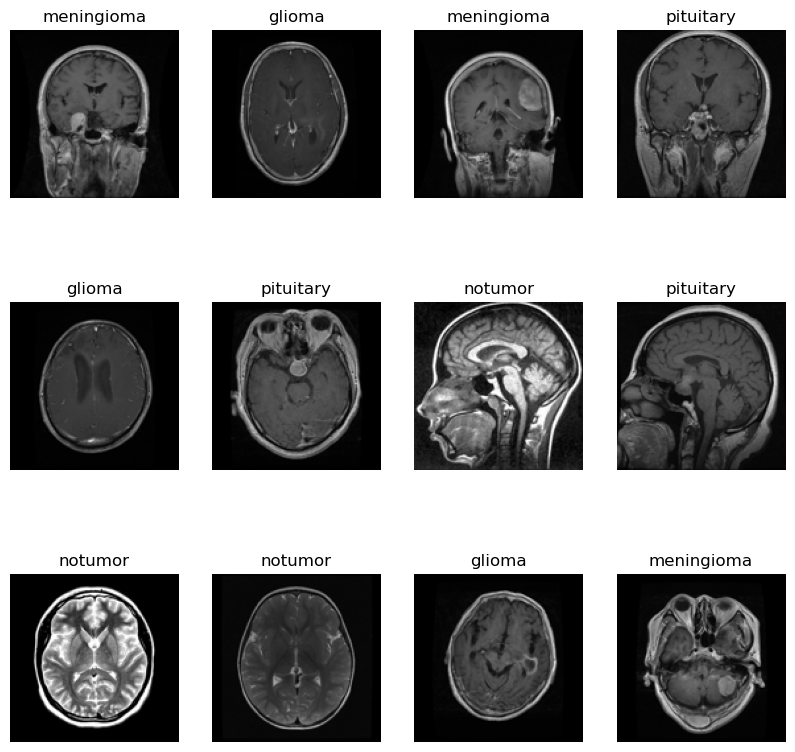

In [11]:
plt.figure(figsize=(10, 10))
indices = np.random.choice(len(train_images), 12, replace=False)

for i, idx in enumerate(indices):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(train_images[idx])
    plt.title(class_labels[np.argmax(train_labels_one_hot[idx])])
    plt.axis('off')

plt.show()

## Data Augmentation

In [12]:

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)


In [13]:
train_generator = datagen.flow(train_images, train_labels_one_hot, batch_size=32)

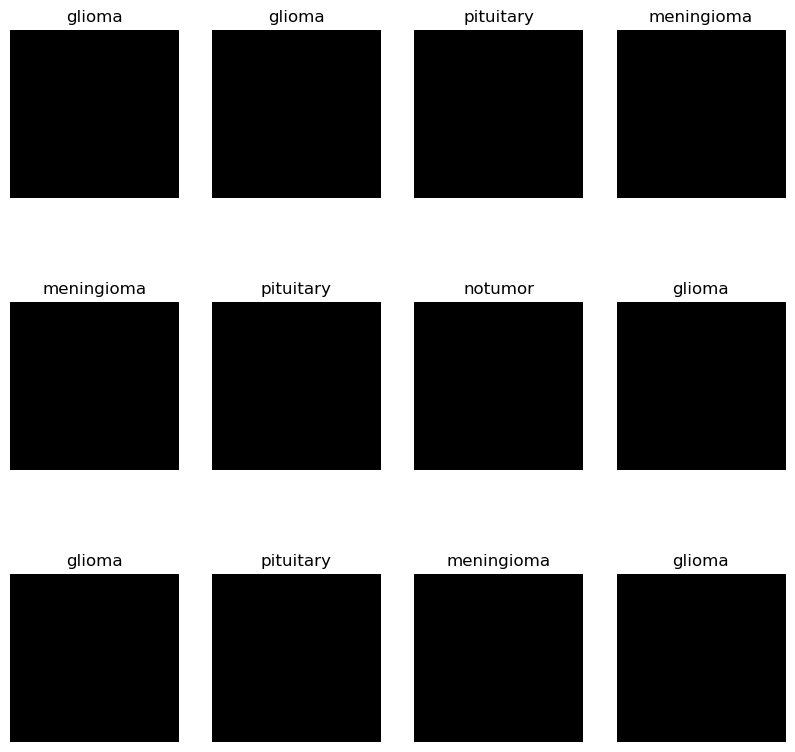

In [14]:
# For demonstration, plot augmented images
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    break  # Only take the first batch for plotting

plt.show()

## RESNET

In [15]:
# Define paths for saved models
input_path = 'RESNET/saved-model/'
working_path = 'RESNET/working-model/'

# Custom callback to print when the model is saved
class MyModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if self.save_best_only:
            current_value = logs.get(self.monitor)
            if current_value == self.best:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current_value}, saving model weights to {self.filepath}")
                # Save model weights
                model.save_weights(os.path.join(working_path, 'best_model_weights.weights.h5'))
                
                # Save model architecture
                model_json = model.to_json()
                with open(os.path.join(working_path, 'best_model_architecture.json'), 'w') as json_file:
                    json_file.write(model_json)


In [16]:

# Function to load model if files exist
def load_model_if_exists(model_path, weight_file, arch_file):
    if os.path.exists(weight_file) and os.path.exists(arch_file):
        with open(arch_file, 'r') as json_file:
            loaded_model_json = json_file.read()
        loaded_model = tf.keras.models.model_from_json(loaded_model_json)
        loaded_model.load_weights(weight_file)
        print("Model loaded from saved files.")
        return loaded_model
    return None


def convert_tensor_to_list(value):
    if isinstance(value, tf.Tensor):
        return value.numpy().tolist()
    return value

In [17]:

# Check if saved model exists and load it
model = load_model_if_exists(
    working_path, 
    os.path.join(working_path, 'best_model_weights.weights.h5'), 
    os.path.join(working_path, 'best_model_architecture.json')
)

if model is None:
    model = load_model_if_exists(
        input_path, 
        os.path.join(input_path, 'best_model_weights.weights.h5'), 
        os.path.join(input_path, 'best_model_architecture.json')
    )
    if model:
        with open(os.path.join(input_path, 'history.json'), 'r') as file:
            history = json.load(file)


Model loaded from saved files.


In [18]:

if model is None:
    print("No saved model found. Training a new model...")

    # Load ResNet50 model without the top layers and with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)  # Change the number of classes to 4

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy',
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.F1Score()])

    # Define ModelCheckpoint callback to save the best model
    checkpoint = MyModelCheckpoint(
        filepath='best_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    )

    # Train the model and save training history
    history = model.fit(
        train_images, 
        train_labels_one_hot, 
        epochs=10,
        batch_size=32,
        validation_data=(test_images, test_labels_one_hot), 
        callbacks=[checkpoint]
    )

    # Save training history
    history_dict = {}
    for key, value in history.history.items():
        history_dict[key] = [convert_tensor_to_list(val) for val in value]

    with open(os.path.join(working_path, 'history.json'), 'w') as file:
        json.dump(history_dict, file)

    # Verify if the model files were saved successfully
    if os.path.exists(os.path.join(working_path, 'best_model_weights.weights.h5')) and os.path.exists(os.path.join(working_path, 'best_model_architecture.json')):
        print("Model saved successfully.")
    else:
        print("Model was not saved.")


## Evaluation:

In [30]:
# Evaluate the model on the test data
test_loss_res, test_accuracy_res = model.evaluate(test_images, test_labels_one_hot, verbose=2)[:2]
print(f"Test Loss: {test_loss_res}")
print(f"Test Accuracy: {test_loss_res}")

# Get the predicted labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_one_hot, axis=1)

# Calculate precision, recall, and F1 score
precision_res = precision_score(true_labels, predicted_labels, average='weighted')
recall_res = recall_score(true_labels, predicted_labels, average='weighted')
f1_res = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision_res}")
print(f"Recall: {recall_res}")
print(f"F1 Score: {f1_res}")


41/41 - 16s - 397ms/step - accuracy: 0.7582 - auc: 0.9419 - f1_score: 0.7470 - loss: 0.5678 - precision: 0.7871 - recall: 0.7193
Test Loss: 0.5677772164344788
Test Accuracy: 0.5677772164344788
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 403ms/step
Precision: 0.7772088888257894
Recall: 0.7581998474446987
F1 Score: 0.7553005225360312


In [31]:
# classification report
print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.60      0.90      0.72       300
           1       0.71      0.48      0.57       306
           2       0.90      0.82      0.86       405
           3       0.85      0.81      0.83       300

    accuracy                           0.76      1311
   macro avg       0.77      0.75      0.75      1311
weighted avg       0.78      0.76      0.76      1311



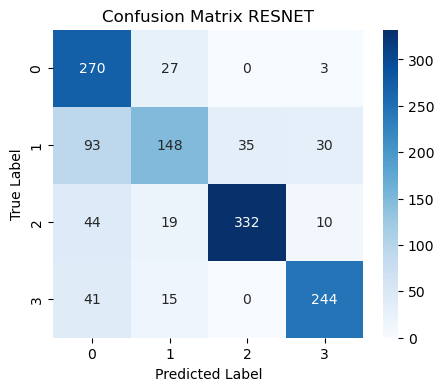

In [32]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# print(conf_matrix)

# Visualize the confusion matrix (optional)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix RESNET')
plt.show()

## GoogleNet Inception V3

In [33]:
# Define paths for saved models
input_path = 'GoogleNet/saved-model/'
working_path = 'GoogleNet/working-model/'


# Check if saved model exists and load it
model = load_model_if_exists(
    working_path, 
    os.path.join(working_path, 'best_model_weights.weights.h5'), 
    os.path.join(working_path, 'best_model_architecture.json')
)

if model is None:
    model = load_model_if_exists(
        input_path, 
        os.path.join(input_path, 'best_model_weights.weights.h5'), 
        os.path.join(input_path, 'best_model_architecture.json')
    )
    if model:
        with open(os.path.join(input_path, 'history.json'), 'r') as file:
            history = json.load(file)


Model loaded from saved files.


In [34]:

if model is None:
    print("No saved model found. Training a new model...")

    # Load InceptionV3 model without the top layers and with pre-trained weights
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)  # Change the number of classes to 4

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy',
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.F1Score()])

    # Define ModelCheckpoint callback to save the best model
    checkpoint = MyModelCheckpoint(
        filepath='best_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    )

    # Train the model and save training history
    history = model.fit(
        train_images, 
        train_labels_one_hot, 
        epochs=10,
        batch_size=32,
        validation_data=(test_images, test_labels_one_hot), 
        callbacks=[checkpoint]
    )

    # Save training history
    history_dict = {}
    for key, value in history.history.items():
        history_dict[key] = [convert_tensor_to_list(val) for val in value]

    with open(os.path.join(working_path, 'history.json'), 'w') as file:
        json.dump(history_dict, file)

    # Verify if the model files were saved successfully
    if os.path.exists(os.path.join(working_path, 'best_model_weights.weights.h5')) and os.path.exists(os.path.join(working_path, 'best_model_architecture.json')):
        print("Model saved successfully.")
    else:
        print("Model was not saved.")


## Evaluation

In [38]:
# Evaluate the model on the test data
test_loss_inc, test_accuracy_inc = model.evaluate(test_images, test_labels_one_hot, verbose=2)[:2]
print(f"Test Loss: {test_loss_inc}")
print(f"Test Accuracy: {test_accuracy_inc}")

# Get the predicted labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_one_hot, axis=1)

# Calculate precision, recall, and F1 score
precision_inc = precision_score(true_labels, predicted_labels, average='weighted')
recall_inc = recall_score(true_labels, predicted_labels, average='weighted')
f1_inc = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision_inc}")
print(f"Recall: {recall_inc}")
print(f"F1 Score: {f1_inc}")


41/41 - 9s - 223ms/step - accuracy: 0.9443 - auc_1: 0.9938 - f1_score: 0.9396 - loss: 0.1663 - precision_1: 0.9470 - recall_1: 0.9413
Test Loss: 0.16628147661685944
Test Accuracy: 0.9443173408508301
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step
Precision: 0.9454123212980355
Recall: 0.9443173150266971
F1 Score: 0.944038040228186


In [39]:
# classification report
print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.96      0.87      0.91       300
           1       0.90      0.91      0.90       306
           2       1.00      1.00      1.00       405
           3       0.91      0.98      0.94       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



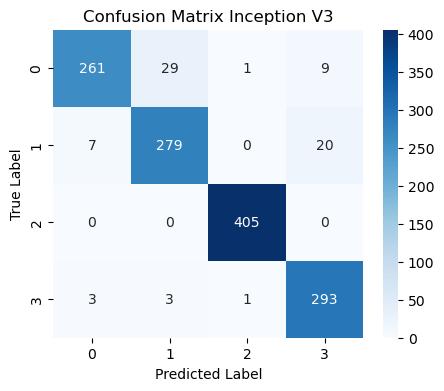

In [40]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# print(conf_matrix)

# Visualize the confusion matrix (optional)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Inception V3')
plt.show()

## Custom Model with 5 CNNs and MaxPooling layers

In [41]:
model = models.Sequential()

# 1st Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 4th Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 5th Convolutional Layer
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,062,852 (4.05 MB)

 Trainable params: 1,062,852 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Define paths for saved models
input_path = 'CustomModel/saved-model/'
working_path = 'CustomModel/working-model/'


model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.F1Score()])

# Define ModelCheckpoint callback to save the best model
checkpoint = MyModelCheckpoint(
    filepath='best_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

# Train the model and save training history
history = model.fit(
    train_images, 
    train_labels_one_hot, 
    epochs=10,
    batch_size=32,
    validation_data=(test_images, test_labels_one_hot), 
    callbacks=[checkpoint]
)


history_dict = {}
for key, value in history.history.items():
    history_dict[key] = [convert_tensor_to_list(val) for val in value]
    
with open(os.path.join(working_path, 'history.json'), 'w') as file:
    json.dump(history_dict, file)

# Verify if the model files were saved successfully
if os.path.exists(os.path.join(working_path, 'best_model_weights.weights.h5')) and os.path.exists(os.path.join(working_path, 'best_model_architecture.json')):
    print("Model saved successfully.")
else:
    print("Model was not saved.")


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4849 - auc: 0.7524 - f1_score: 0.4542 - loss: 1.0755 - precision: 0.7394 - recall: 0.2807
Epoch 1: val_accuracy improved from -inf to 0.70023, saving model to best_model.keras
Epoch 1: val_accuracy improved to 0.7002288103103638, saving model weights to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.4857 - auc: 0.7531 - f1_score: 0.4551 - loss: 1.0742 - precision: 0.7396 - recall: 0.2819 - val_accuracy: 0.7002 - val_auc: 0.9120 - val_f1_score: 0.6400 - val_loss: 0.7138 - val_precision: 0.7472 - val_recall: 0.6606
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7971 - auc: 0.9538 - f1_score: 0.7828 - loss: 0.5123 - precision: 0.8245 - recall: 0.7618
Epoch 2: val_accuracy improved from 0.70023 to 0.78490, saving model to best_model.keras
Epoch 2: val_accuracy improved to 0.7848970293998718, saving model weights to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 176ms/step

In [43]:
# Evaluate the model on the test data
test_loss_custom, test_accuracy_custom = model.evaluate(test_images, test_labels_one_hot, verbose=2)[:2]
print(f"Test Loss: {test_loss_custom}")
print(f"Test Accuracy: {test_accuracy_custom}")

# Get the predicted labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_one_hot, axis=1)

# Calculate precision, recall, and F1 score
precision_custom = precision_score(true_labels, predicted_labels, average='weighted')
recall_custom = recall_score(true_labels, predicted_labels, average='weighted')
f1_custom = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision_custom}")
print(f"Recall: {recall_custom}")
print(f"F1 Score: {f1_custom}")


41/41 - 2s - 56ms/step - accuracy: 0.9725 - auc: 0.9975 - f1_score: 0.9702 - loss: 0.1042 - precision: 0.9733 - recall: 0.9718
Test Loss: 0.10423220694065094
Test Accuracy: 0.972540020942688
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
Precision: 0.9726465495970288
Recall: 0.9725400457665904
F1 Score: 0.9725125979807712


In [44]:
# classification report
print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       300
           1       0.96      0.93      0.95       306
           2       1.00      1.00      1.00       405
           3       0.98      0.99      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



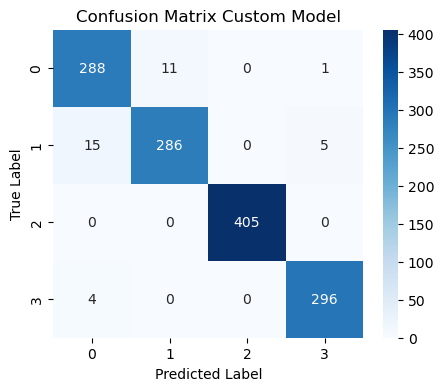

In [45]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# print(conf_matrix)

# Visualize the confusion matrix (optional)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Custom Model')
plt.show()

In [50]:

eval_data = {
    'Model': ['RESNET', 'INCEPTION V3', 'Custom Model'],
    'Accuracy': [test_accuracy_res, test_accuracy_inc, test_accuracy_custom],
    'Precision': [precision_res, precision_inc, precision_custom],
    'Recall': [recall_res, recall_inc, recall_custom],
    'F1 Score': [f1_res, f1_inc, f1_custom]
}

df = pd.DataFrame(eval_data)



In [51]:
df

,Model,Accuracy,Precision,Recall,F1 Score
0,RESNET,0.758200,0.777209,0.758200,0.755301
1,INCEPTION V3,0.944317,0.945412,0.944317,0.944038
2,Custom Model,0.972540,0.972647,0.972540,0.972513


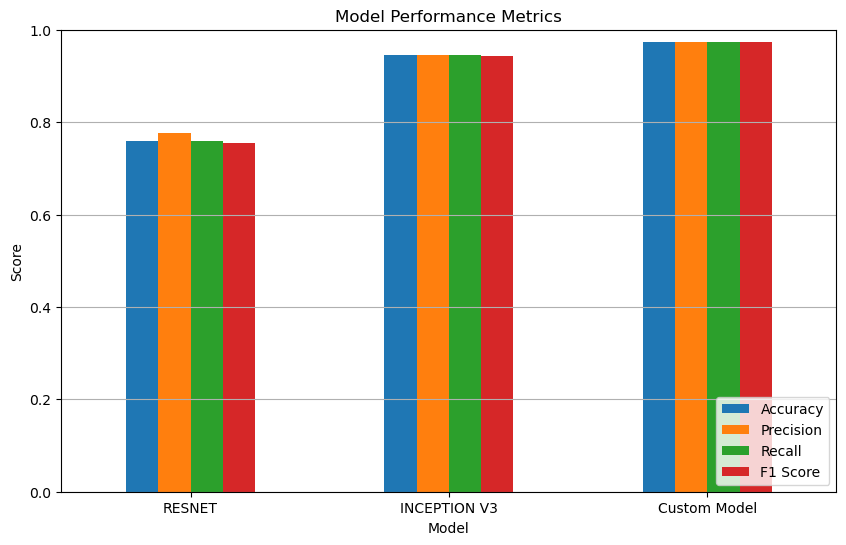

In [52]:

# Create a bar plot
df.set_index('Model').plot(kind='bar', figsize=(10, 6))

plt.title('Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()
